In [1]:
import numpy as np
import pandas as pd
import math
from models.ContentBoostedCFModel import ContentBoostedCFModel
import re
import nltk
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mimi_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
RAW_DATA_PATH = '../data/ml-latest-small'
PROCESSED_DATA_PATH = '../data/processed_data'

In [3]:
ratings_data = pd.read_csv(f'{RAW_DATA_PATH}/ratings.csv')
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
plots_data = pd.read_csv(f'{PROCESSED_DATA_PATH}/movie_plots_imdb.csv')
plots_data.head()

,movieId,plot
0,1,"[""A cowboy doll is profoundly threatened and j..."
1,2,['When two kids find and play a magical board ...
2,3,"[""John and Max resolve to save their beloved b..."
3,4,"[""Based on Terry McMillan's novel, this film f..."
4,5,['George Banks must deal not only with the pre...


In [5]:
ratings_plots = ratings_data.merge(plots_data, on='movieId', how='inner')
ratings_plots.head()

,userId,movieId,rating,timestamp,plot
0,1,1,4.0,964982703,"[""A cowboy doll is profoundly threatened and j..."
1,5,1,4.0,847434962,"[""A cowboy doll is profoundly threatened and j..."
2,7,1,4.5,1106635946,"[""A cowboy doll is profoundly threatened and j..."
3,15,1,2.5,1510577970,"[""A cowboy doll is profoundly threatened and j..."
4,17,1,4.5,1305696483,"[""A cowboy doll is profoundly threatened and j..."


In [6]:
def normalize_plots(data): 
  stemmer = SnowballStemmer("english", ignore_stopwords=False)
  normalized = []
  for x in data:
    words = nltk.word_tokenize(x)
    normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
  return normalized

In [7]:
unique_plots = {}
for mid, p in zip(ratings_plots.movieId.values, ratings_plots['plot'].values):
    unique_plots[mid] = p

In [8]:
pipe = Pipeline([
  ('normalize', FunctionTransformer(normalize_plots, validate=False)),
  ('counter_vectorizer', CountVectorizer(
    max_df=0.8, max_features=50000,
    min_df=0.1, stop_words='english',
    ngram_range=(1,5)
  )),
  ('tfidf_transform', TfidfTransformer())
])
tfidf_matrix = pipe.fit_transform([x for x in unique_plots.values()])

In [9]:
tfidf_matrix.todense().shape

(9715, 145)

In [10]:
plots_vectorized = []
for mid, p in zip(unique_plots.keys(), tfidf_matrix.todense()):
    node = {}
    p = p.tolist()[0]
    node['movieId'] = mid
    for i in range(len(p)):
        node[i] = p[i]
    plots_vectorized.append(node)

In [11]:
df_tf_idf = pd.DataFrame(plots_vectorized)

In [12]:
ratings_with_tf_idf = ratings_plots.merge(df_tf_idf, on='movieId', how='inner')

In [13]:
ratings_with_tf_idf.to_csv('../results/ratings_with_tf_idf.csv', index=False)

In [14]:
dict_movies = {}
count = 0
for _id in sorted(np.unique(ratings_with_tf_idf.movieId)):
    if _id not in dict_movies.keys():
        dict_movies[_id] = count
        count += 1        

In [15]:
ratings_with_tf_idf = ratings_with_tf_idf.replace({'movieId': dict_movies})

In [16]:
N_USERS = len(np.unique(ratings_with_tf_idf['userId']))
N_MOVIES = len(np.unique(ratings_with_tf_idf['movieId']))

In [17]:
print(f'Number of users in the data set: {N_USERS} \nNumber of movies in the data set: {N_MOVIES}')

Number of users in the data set: 610 
Number of movies in the data set: 9715


In [18]:
ratings_with_tf_idf.userId = ratings_with_tf_idf.userId - 1

In [19]:
LATENT_FACTORS = [3, 10, 100, 300]

In [20]:
train_data, test_data = train_test_split(ratings_with_tf_idf,
                                         test_size = 0.2, 
                                         random_state = 0)

In [21]:
movies_data = pd.read_csv(f'{RAW_DATA_PATH}/movies.csv')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
USER_ID = 5
MOVIES_TO_RECOMMEND = 3

In [23]:
ratings_with_tf_idf[ratings_with_tf_idf.userId == USER_ID].sort_values('rating', axis=0, ascending = False).head(20)

,userId,movieId,rating,timestamp,plot,0,1,2,3,4,...,135,136,137,138,139,140,141,142,143,144
216,5,2,5.0,845554296,"[""John and Max resolve to save their beloved b...",0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162609,0.000000
5339,5,614,5.0,845556915,"[""The aliens are coming and their goal is to i...",0.000000,0.000000,0.080289,0.000000,0.086217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.397022,0.000000,0.000000,0.000000,0.000000
16298,5,277,5.0,845553200,['Two imprisoned men bond over a number of yea...,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.323578,0.382303,0.000000,0.000000,0.109209,0.000000,0.000000,0.198260,0.000000
19601,5,326,5.0,845553726,"['Bret Maverick, needing money for a poker tou...",0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.244404,0.000000,0.370679,0.000000,0.000000,0.111819,0.111988,0.000000,0.000000
19914,5,506,5.0,845553146,['A kindhearted street urchin and a power-hung...,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.076238,0.000000,0.000000,0.000000,0.000000,0.074155
20097,5,512,5.0,845553174,"[""A prince cursed to spend his days as a hideo...",0.000000,0.000000,0.120062,0.000000,0.000000,...,0.000000,0.048863,0.000000,0.111163,0.000000,0.000000,0.000000,0.000000,0.089817,0.318928
25138,5,33,5.0,845553726,"[""A nun, while comforting a convicted killer o...",0.113289,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.079717,0.000000,0.000000,0.000000,0.000000,0.000000
26122,5,322,5.0,845553317,['Lion prince Simba and his father are targete...,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.070855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130241,0.396401
27240,5,4,5.0,845553938,['George Banks must deal not only with the pre...,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.576463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27811,5,21,5.0,845553875,['An agoraphobic psychologist and a female det...,0.000000,0.000000,0.102623,0.000000,0.110200,...,0.000000,0.000000,0.000000,0.000000,0.080074,0.084577,0.000000,0.000000,0.000000,0.000000


In [24]:
reverse_dict_movies = {}
for item in dict_movies.items():
    reverse_dict_movies[item[1]] = item[0]

In [25]:
movies_wathced_by_user = ratings_with_tf_idf[ratings_with_tf_idf.userId == USER_ID]
movies_not_watched = movies_data[~movies_data["movieId"].isin(movies_wathced_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(dict_movies.keys()))
)
movies_not_watched = [[dict_movies.get(x)] for x in movies_not_watched]

In [26]:
matrix_tf_idf = ratings_with_tf_idf.drop_duplicates(subset='movieId', keep='last').sort_values('movieId')[ratings_with_tf_idf.columns[5:]].values

tf_idf_matrix is not None: True
Model: "MatrixFactorizationReccomender"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MoviesInput (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
UsersInput (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
MoviesEmbedding (Embedding)     (None, 1, 19)        184585      MoviesInput[0][0]                
__________________________________________________________________________________________________
UsersEmbedding (Embedding)      (None, 1, 19)        11590       UsersInput[0][0]                 
_____________________________________

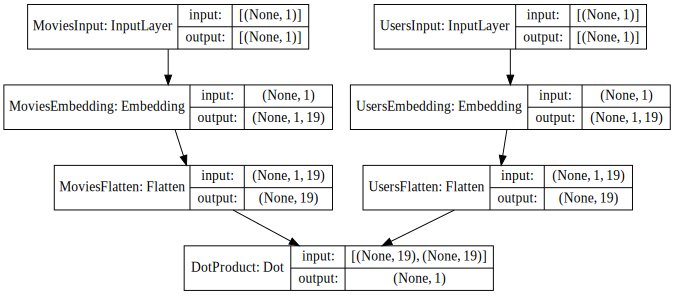

Epoch 1/100
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
134/134 [==============================] - 41s 146ms/step - loss: 40.9378 - mae: 3.4998 - mse: 13.3381 - val_loss: 37.8195 - val_mae: 3.5001 - val_mse: 13.3454
Epoch 2/100
134/134 [==============================] - 12s 88ms/step - loss: 35.3564 - mae: 3.5001 - mse: 13.3398 - val_loss: 33.0407 - val_mae: 3.5004 - val_mse: 13.3472
Epoch 3/100
134/134 [==============================] - 12s 87ms/step - loss: 31.0600 - mae: 3.5003 - mse: 13.3415 - val_loss: 29.1999 - val_mae: 3.5006 - val_mse: 13.3488
Epoch 4/100
134/134 [==============================] - 12s 90ms/step - loss: 27.6057 - mae: 3.5005 - mse: 13.3430 - val_loss: 26.1106 - val_mae: 3.5008 - val_mse: 13.3502
Epoch 5/100
134/134 [==============================] - 12s 86ms/step - loss: 24.8264 - mae: 3.5007 - mse: 13.3444 - val_loss: 23.6243 - val_mae: 3.5010 - val_mse: 13.3515
Epoch 

134/134 [==============================] - 13s 96ms/step - loss: 13.0089 - mae: 3.5025 - mse: 13.3564 - val_loss: 13.0062 - val_mae: 3.5026 - val_mse: 13.3629
Epoch 47/100
134/134 [==============================] - 12s 93ms/step - loss: 12.9904 - mae: 3.5025 - mse: 13.3564 - val_loss: 12.9872 - val_mae: 3.5026 - val_mse: 13.3629
Epoch 48/100
134/134 [==============================] - 12s 92ms/step - loss: 12.9708 - mae: 3.5025 - mse: 13.3564 - val_loss: 12.9671 - val_mae: 3.5026 - val_mse: 13.3629
Epoch 49/100
134/134 [==============================] - 12s 90ms/step - loss: 12.9503 - mae: 3.5025 - mse: 13.3564 - val_loss: 12.9460 - val_mae: 3.5026 - val_mse: 13.3629
Epoch 50/100
134/134 [==============================] - 12s 90ms/step - loss: 12.9285 - mae: 3.5025 - mse: 13.3564 - val_loss: 12.9237 - val_mae: 3.5026 - val_mse: 13.3629
Epoch 51/100
134/134 [==============================] - 12s 90ms/step - loss: 12.9056 - mae: 3.5025 - mse: 13.3564 - val_loss: 12.9001 - val_mae: 3.5026 

Epoch 94/100
134/134 [==============================] - 12s 90ms/step - loss: 8.0922 - mae: 3.5023 - mse: 13.3555 - val_loss: 7.9337 - val_mae: 3.5025 - val_mse: 13.3620
Epoch 95/100
134/134 [==============================] - 12s 90ms/step - loss: 7.7577 - mae: 3.5023 - mse: 13.3554 - val_loss: 7.5883 - val_mae: 3.5025 - val_mse: 13.3620
Epoch 96/100
134/134 [==============================] - 12s 89ms/step - loss: 7.4011 - mae: 3.5023 - mse: 13.3554 - val_loss: 7.2200 - val_mae: 3.5025 - val_mse: 13.3620
Epoch 97/100
134/134 [==============================] - 13s 95ms/step - loss: 7.0208 - mae: 3.5023 - mse: 13.3554 - val_loss: 6.8272 - val_mae: 3.5025 - val_mse: 13.3619
Epoch 98/100
134/134 [==============================] - 12s 89ms/step - loss: 6.6152 - mae: 3.5023 - mse: 13.3553 - val_loss: 6.4083 - val_mae: 3.5025 - val_mse: 13.3619
Epoch 99/100
134/134 [==============================] - 12s 93ms/step - loss: 6.1825 - mae: 3.5023 - mse: 13.3553 - val_loss: 5.9614 - val_mae: 3.5025

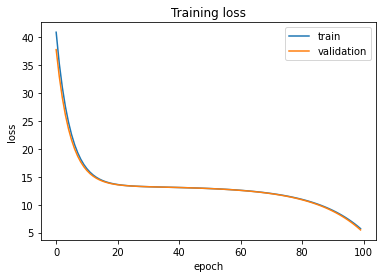

Reccomendations with 19 latent factors:
[1564 6580 6737]
Recommended 3 movies with 19 latent factors: 

      movieId                    title                   genres
1567     2105              Tron (1982)  Action|Adventure|Sci-Fi
6599    55444           Control (2007)                    Drama
6756    59725  Sex and the City (2008)           Comedy|Romance


In [27]:
model_array = []
lf = 19

model = ContentBoostedCFModel(N_USERS, N_MOVIES , lf, tf_idf_matrix = matrix_tf_idf)
print(f'tf_idf_matrix is not None: {model.tf_idf_matrix is not None}')
model.compile(loss_function = 'mean_squared_error', lr=0.001)
model.train(train_data, epochs = 100, batch = 512)
#model.save(f'./trained_models/tf_idf/{lf}_latent_factors')
#model.load_model(f'./trained_models/tf_idf/{lf}_latent_factors')
movie_embeddings = model.get_movies_embeddings()
movie_embeddings_frame = pd.DataFrame(movie_embeddings)
movie_embeddings_frame['movieId'] = list(dict_movies.values())
movie_embeddings_frame.to_csv(f'../results/movie_embeddings/movie_embeddings_tf_idf_{lf}_latent_factors.csv')
    
user_embedding_learnt = model.model.get_layer(name='UsersEmbedding').get_weights()[0][USER_ID]
memb = movie_embeddings[movies_not_watched]
memb = memb.reshape(memb.shape[0], lf)
movies = user_embedding_learnt @ memb.T
recommendations = np.argpartition(movies, -MOVIES_TO_RECOMMEND)[-MOVIES_TO_RECOMMEND:]
print(f'Reccomendations with {lf} latent factors:\n{recommendations}')
recommended_movies_ids = []
for val in recommendations:
    recommended_movies_ids.append(reverse_dict_movies[val])
print(f'Recommended {MOVIES_TO_RECOMMEND} movies with {lf} latent factors: \n')
print(movies_data[movies_data.movieId.isin(recommended_movies_ids)])
user_embeddings = pd.DataFrame(model.model.get_layer(name='UsersEmbedding').get_weights()[0])
user_embeddings['userId'] = np.arange(1, 611)
user_embeddings.to_csv(f'../results/movie_embeddings/user_embeddings_tf_idf_{lf}_latent_factors.csv', index=False)

In [28]:
print(f'Evaluation root mean squared error: {np.sqrt(mean_squared_error(ratings_with_tf_idf.rating, model.predict(ratings_with_tf_idf)))}')

Evaluation root mean squared error: 3.6529162254017917


<b><font color='red'>There was an error when saving the model. Only the movie and user embeddings were saved.</font></b>